Carga de ruta de datos al modelo:

In [1]:
import os
import glob as gb
import cv2
import torch
from torchvision import datasets, models,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from skimage.feature import graycomatrix, graycoprops

In [2]:
train_path = "/kaggle/input/skin-burns-dataset/skin burn dataset/train/"
test_path = "/kaggle/input/skin-burns-dataset/skin burn dataset/test/"
val_path = "/kaggle/input/skin-burns-dataset/skin burn dataset/valid/"

In [3]:
if torch.cuda.is_available():
    print(f"GPUs disponibles: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No se detectaron GPUs")

GPUs disponibles: 1
GPU 0: Tesla P100-PCIE-16GB


Cargamos los datos de entrenamiento cagetegorizados por carpetas

In [4]:
from PIL import Image

class_ = {'1st degree burn': 0, '2nd degree burn': 1 , '3nd degree burn': 2}

train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(128),  # Cambiamos el tamaño al valor más pequeño, puede ser ancho o alto
    transforms.CenterCrop(128),  # Ahora recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización basada en las estadísticas
])


val_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)  #aqui con shuffle = True le otorgamos aleatoriedad a la carga de las imagenes
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False)

In [5]:
import torch

# Obtener un batch de imágenes del train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Imprimir el shape del primer batch de imágenes
print("Shape del batch de imágenes de entrenamiento:", images.shape)

# Imprimir el shape de una imagen individual del batch
print("Shape de una imagen individual:", images[0].shape)

Shape del batch de imágenes de entrenamiento: torch.Size([32, 3, 128, 128])
Shape de una imagen individual: torch.Size([3, 128, 128])


In [6]:
print(train_loader.dataset.classes)
print(val_loader.dataset.classes)

['1st degree burn', '2nd degree burn', '3nd degree burn']
['1st degree burn', '2nd degree burn', '3nd degree burn']


<PIL.Image.Image image mode=RGB size=128x128 at 0x7B16CBAE3640>


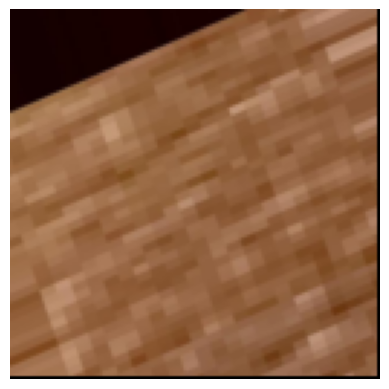

In [8]:
'''
Ahora se debe de conseguir que las imagenes sean todas cuadradas, ya que el resize cambiaba el aspecto de la imagen



utilizar el centro crop
'''

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Ruta de la imagen
x = '/kaggle/input/skin-burns-dataset/skin burn dataset/train/1st degree burn/0_img0_jpg.rf.4a98fef2cf2e898395aa0ebf8eec50bc.jpg'

# Cargar la imagen
image = Image.open(x)

# Aplicar la transformación de redimensionamiento
transform = transforms.Resize(size= 127, max_size = 128)
transform2 = transforms.CenterCrop(128)
resized_image = transform2(transform(image))
print(resized_image)

# Mostrar la imagen transformada
plt.imshow(resized_image)
plt.axis('off')  # Opcional: quita los ejes
plt.show()

#solo usar para entrenar el modelo

In [9]:
import matplotlib.pyplot as plt

# Mostrar algunas imágenes de entrenamiento
def Show_images(loader):
    plt.figure(figsize=(10, 15))
    for n, (images, labels) in enumerate(loader):
        if n >= 36:
            break
        image = images[0]  # Selecciona la primera imagen del lote
        label = labels[0]  # Selecciona la primera etiqueta del lote
        plt.subplot(6, 6, n + 1)
        image = image.permute(1, 2, 0)  # Reordenar los ejes para mostrar la imagen
        plt.imshow((image * 0.5 + 0.5).numpy())  # Des-normalizar la imagen para mostrarla
        plt.axis('off')
        plt.title([key for key, value in class_.items() if value == label.item()][0], fontsize=10)
    plt.show()

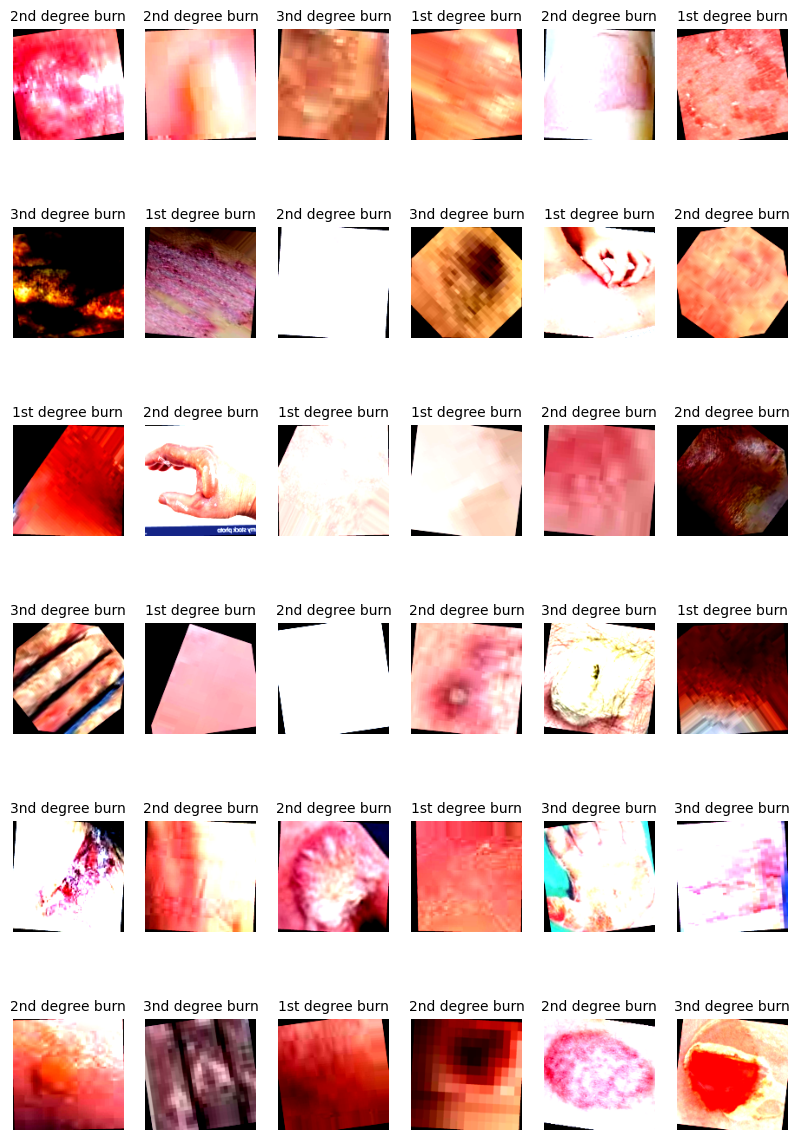

In [10]:
Show_images(train_loader)

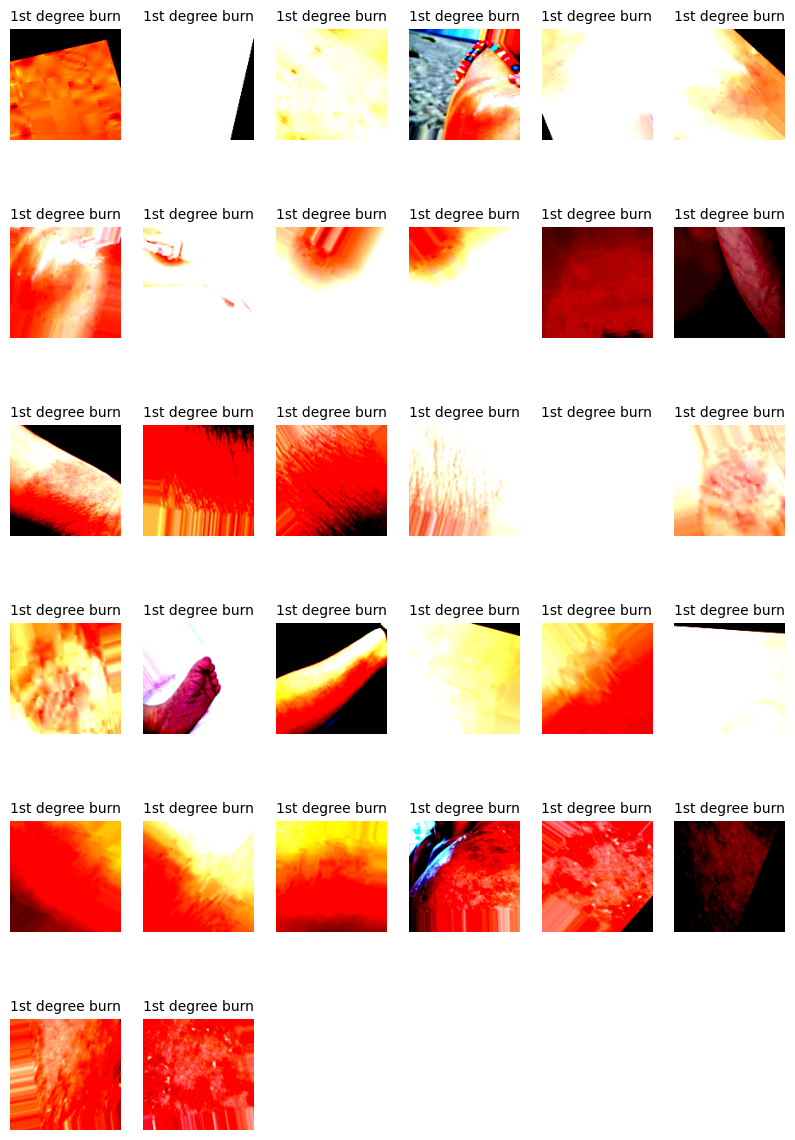

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un batch de imágenes del val_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Mostrar 36 imágenes del batch
plt.figure(figsize=(10, 15))
for n in range(36):
    if n >= len(images):  # no sobrepasar el número de imágenes en el batch
        break
    image = images[0]  # Selecciona la primera imagen del lote
    label = labels[0]  # Selecciona la primera etiqueta del lote
    plt.subplot(6, 6, n + 1)
    plt.imshow(images[n].permute(1, 2, 0))  # Cambia las dimensiones de [C, H, W] a [H, W, C] para visualizar
    plt.axis('off')
    plt.title([key for key, value in class_.items() if value == label.item()][0], fontsize=10)

plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Inicializar el modelo VGG16 con los pesos preentrenados de ImageNet
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Reemplazar la última capa fully connected para 3 clases
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 3)

# Enviar el modelo al dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Poner el modelo en modo de evaluación
model.eval()

# Imprimir la confirmación de carga de modelo
print("Modelo VGG16 cargado y ajustado correctamente con pesos preentrenados de ImageNet")

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 201MB/s]  


Modelo VGG16 cargado y ajustado correctamente con pesos preentrenados de ImageNet


In [13]:
# Ruta para guardar el modelo
save_path = '/kaggle/working/vgg16_burn_classification.pth'

# Guardar los pesos del modelo
torch.save(model.state_dict(), save_path)

print(f"Modelo guardado correctamente en: {save_path}")

Modelo guardado correctamente en: /kaggle/working/vgg16_burn_classification.pth


In [19]:
# Inicializar un nuevo modelo VGG16 con la misma arquitectura
vgg16 = models.vgg16(weights=None)

# Reemplazar la última capa fully connected para 3 clases
num_ftrs = model.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 3)

# Enviar el modelo al dispositivo
vgg16 = vgg16.to(device)

# Cargar los pesos guardados desde Kaggle
load_path = '/kaggle/working/vgg16_burn_classification.pth'
vgg16.load_state_dict(torch.load(load_path))

# Poner el modelo en modo de evaluación
model.eval()

print(f"Modelo cargado correctamente desde: {load_path}")

/tmp/ipykernel_30/4256053939.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16.load_state_dict(torch.load(load_path))


Modelo cargado correctamente desde: /kaggle/working/vgg16_burn_classification.pth


In [17]:
from sklearn.metrics import f1_score

In [20]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image

# Ajustar los hiperparámetros
learning_rate = 0.001  # Learning rate más bajo
weight_decay = 1e-4 # Regularización con Weight Decay

# Descongelar más capas
for param in vgg16.features[-4:].parameters():  # Últimas 4 capas convolucionales
    param.requires_grad = True

train_labels = [label for _, label in train_dataset]

# Definir optimizador y función de pérdida
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Puedes ajustar el learning rate según tu caso
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Para clasificación multiclase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float('inf')
best_val_accuracy = 0.0

# Suponiendo que tienes el train_loader ya configurado y el modelo ajustado
k_folds = 5
num_epochs = 10
num_classes = 3
results = {}
conf_matrix = np.zeros((len(class_), len(class_)))

# Preparar K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold+1}/{k_folds}')

    best_accuracy = 0.0
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_subsampler)
    
    # Cargar el modelo preentrenado VGG16
    vgg16 = models.vgg16(pretrained = True)

    # Freeze all layers except the last few
    for param in vgg16.features.parameters():
       param.requires_grad = False
    
    # Modificar la última capa classifier
    num_ftrs = vgg16.classifier[0].in_features

# Modificar la parte fully connected del modelo VGG16 con más Dropout y valores más bajos
    vgg16.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 1024),  # Aumentar a 1024 neuronas
        nn.ReLU(),
        nn.Dropout(0.3),  # Dropout más bajo en la primera capa
        nn.Linear(1024, 512),  # Segunda capa con 512 neuronas
        nn.ReLU(),
        nn.Dropout(0.3),  # Dropout más bajo en la segunda capa
        nn.Linear(512, 256),  # Tercera capa con 256 neuronas
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout adicional al final
        nn.Linear(256, num_classes)  # Capa de salida con el número de clases
    )
    
    vgg16 = vgg16.to(device)
    
    # Definir el optimizador (solo entrenamos la capa classifier)
    optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

    # Definir la función de pérdida (con pesos de clases si es necesario)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
            
    # Ciclo de entrenamiento para cada fold
    for epoch in range(num_epochs):
        vgg16.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calcular la pérdida acumulada y la precisión
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())
    
        train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(all_preds_train) == np.array(all_labels_train))
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

        # Almacenar métricas de entrenamiento
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
        
        # Validación y cálculo de matriz de confusión
        vgg16.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss_val / len(val_loader)
        val_acc = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        # Almacenar métricas de validación
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        scheduler.step(val_loss)
        
        # Imprimir las métricas de entrenamiento y validación para la época actual
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, '
              f'Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Guardar el mejor modelo basado en la precisión de validación
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(vgg16.state_dict(), 'vgg16_entrenado.pth')
            print('Modelo mejorado, guardado.')

    # Actualizar la matriz de confusión
    conf_matrix += confusion_matrix(all_labels, all_preds)

    # Guardar los resultados por fold
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Precisión en el fold {fold + 1}: {acc:.4f}')
    results[fold] = acc

# Resultados finales
print(f'Resultados de los {k_folds} folds: {results}')
print(f'Promedio de precisión: {np.mean(list(results.values())):.4f}')

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1/5
Epoch [1/10], Training Loss: 0.5817, Validation Loss: 0.4679, Training Accuracy: 0.7377, Validation Accuracy: 0.7833, Training F1 Score: 0.7293, Validation F1 Score: 0.7744
Modelo mejorado, guardado.
Epoch [2/10], Training Loss: 0.4486, Validation Loss: 0.5024, Training Accuracy: 0.8088, Validation Accuracy: 0.7570, Training F1 Score: 0.8002, Validation F1 Score: 0.7437
Epoch [3/10], Training Loss: 0.4085, Validation Loss: 0.3642, Training Accuracy: 0.8295, Validation Accuracy: 0.8495, Training F1 Score: 0.8228, Validation F1 Score: 0.8407
Modelo mejorado, guardado.
Epoch [4/10], Training Loss: 0.3725, Validation Loss: 0.3373, Training Accuracy: 0.8469, Validation Accuracy: 0.8710, Training F1 Score: 0.8405, Validation F1 Score: 0.8639
Modelo mejorado, guardado.
Epoch [5/10], Training Loss: 0.3393, Validation Loss: 0.3121, Training Accuracy: 0.8592, Validation Accuracy: 0.8708, Training F1 Score: 0.8541, Validation F1 Score: 0.8639
Epoch [6/10], Training Loss: 0.3201, Validati

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 0.5764, Validation Loss: 0.4567, Training Accuracy: 0.7454, Validation Accuracy: 0.7949, Training F1 Score: 0.7369, Validation F1 Score: 0.7871
Modelo mejorado, guardado.
Epoch [2/10], Training Loss: 0.4552, Validation Loss: 0.4183, Training Accuracy: 0.8042, Validation Accuracy: 0.8198, Training F1 Score: 0.7960, Validation F1 Score: 0.8128
Modelo mejorado, guardado.
Epoch [3/10], Training Loss: 0.4055, Validation Loss: 0.3677, Training Accuracy: 0.8301, Validation Accuracy: 0.8529, Training F1 Score: 0.8228, Validation F1 Score: 0.8446
Modelo mejorado, guardado.
Epoch [4/10], Training Loss: 0.3709, Validation Loss: 0.3301, Training Accuracy: 0.8469, Validation Accuracy: 0.8648, Training F1 Score: 0.8404, Validation F1 Score: 0.8568
Modelo mejorado, guardado.
Epoch [5/10], Training Loss: 0.3480, Validation Loss: 0.3227, Training Accuracy: 0.8623, Validation Accuracy: 0.8650, Training F1 Score: 0.8567, Validation F1 Score: 0.8585
Modelo mejorado, guardado.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 0.5785, Validation Loss: 0.5128, Training Accuracy: 0.7449, Validation Accuracy: 0.8000, Training F1 Score: 0.7361, Validation F1 Score: 0.7859
Modelo mejorado, guardado.
Epoch [2/10], Training Loss: 0.4458, Validation Loss: 0.4203, Training Accuracy: 0.8111, Validation Accuracy: 0.8382, Training F1 Score: 0.8029, Validation F1 Score: 0.8276
Modelo mejorado, guardado.
Epoch [3/10], Training Loss: 0.4058, Validation Loss: 0.3734, Training Accuracy: 0.8323, Validation Accuracy: 0.8414, Training F1 Score: 0.8251, Validation F1 Score: 0.8337
Modelo mejorado, guardado.
Epoch [4/10], Training Loss: 0.3704, Validation Loss: 0.3793, Training Accuracy: 0.8500, Validation Accuracy: 0.8435, Training F1 Score: 0.8437, Validation F1 Score: 0.8367
Modelo mejorado, guardado.
Epoch [5/10], Training Loss: 0.3450, Validation Loss: 0.3167, Training Accuracy: 0.8589, Validation Accuracy: 0.8711, Training F1 Score: 0.8535, Validation F1 Score: 0.8658
Modelo mejorado, guardado.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 0.5759, Validation Loss: 0.4332, Training Accuracy: 0.7441, Validation Accuracy: 0.8024, Training F1 Score: 0.7353, Validation F1 Score: 0.7927
Modelo mejorado, guardado.
Epoch [2/10], Training Loss: 0.4491, Validation Loss: 0.3891, Training Accuracy: 0.8125, Validation Accuracy: 0.8377, Training F1 Score: 0.8042, Validation F1 Score: 0.8294
Modelo mejorado, guardado.
Epoch [3/10], Training Loss: 0.4019, Validation Loss: 0.3660, Training Accuracy: 0.8323, Validation Accuracy: 0.8559, Training F1 Score: 0.8253, Validation F1 Score: 0.8488
Modelo mejorado, guardado.
Epoch [4/10], Training Loss: 0.3667, Validation Loss: 0.3437, Training Accuracy: 0.8501, Validation Accuracy: 0.8565, Training F1 Score: 0.8443, Validation F1 Score: 0.8494
Modelo mejorado, guardado.
Epoch [5/10], Training Loss: 0.3406, Validation Loss: 0.3586, Training Accuracy: 0.8623, Validation Accuracy: 0.8698, Training F1 Score: 0.8565, Validation F1 Score: 0.8645
Modelo mejorado, guardado.


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 0.5819, Validation Loss: 0.4129, Training Accuracy: 0.7443, Validation Accuracy: 0.8239, Training F1 Score: 0.7349, Validation F1 Score: 0.8164
Modelo mejorado, guardado.
Epoch [2/10], Training Loss: 0.4497, Validation Loss: 0.3922, Training Accuracy: 0.8093, Validation Accuracy: 0.8223, Training F1 Score: 0.8008, Validation F1 Score: 0.8153
Epoch [3/10], Training Loss: 0.4036, Validation Loss: 0.3691, Training Accuracy: 0.8336, Validation Accuracy: 0.8537, Training F1 Score: 0.8254, Validation F1 Score: 0.8484
Modelo mejorado, guardado.
Epoch [4/10], Training Loss: 0.3738, Validation Loss: 0.3251, Training Accuracy: 0.8433, Validation Accuracy: 0.8652, Training F1 Score: 0.8368, Validation F1 Score: 0.8599
Modelo mejorado, guardado.
Epoch [5/10], Training Loss: 0.3456, Validation Loss: 0.3303, Training Accuracy: 0.8590, Validation Accuracy: 0.8541, Training F1 Score: 0.8534, Validation F1 Score: 0.8491
Epoch [6/10], Training Loss: 0.3271, Validation Loss: 

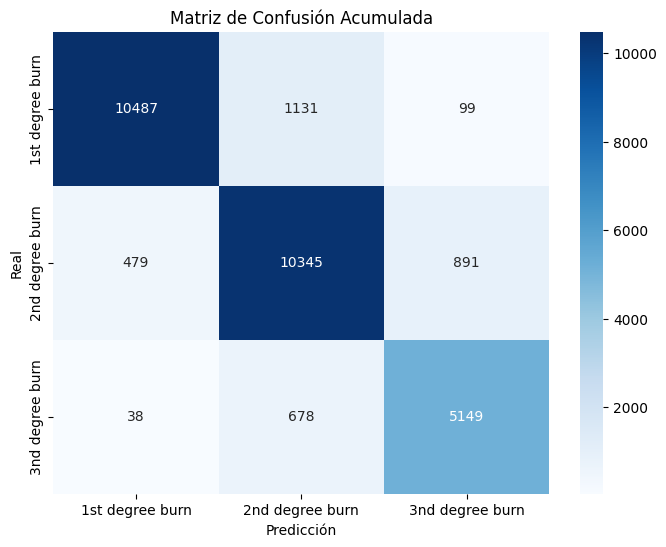

In [21]:
# Graficar la matriz de confusión acumulada
plt.figure(figsize=(8, 6))
class_names = ['1st degree burn', '2nd degree burn', '3nd degree burn']  # Ajustar según las clases que tengas
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Acumulada')
plt.show()

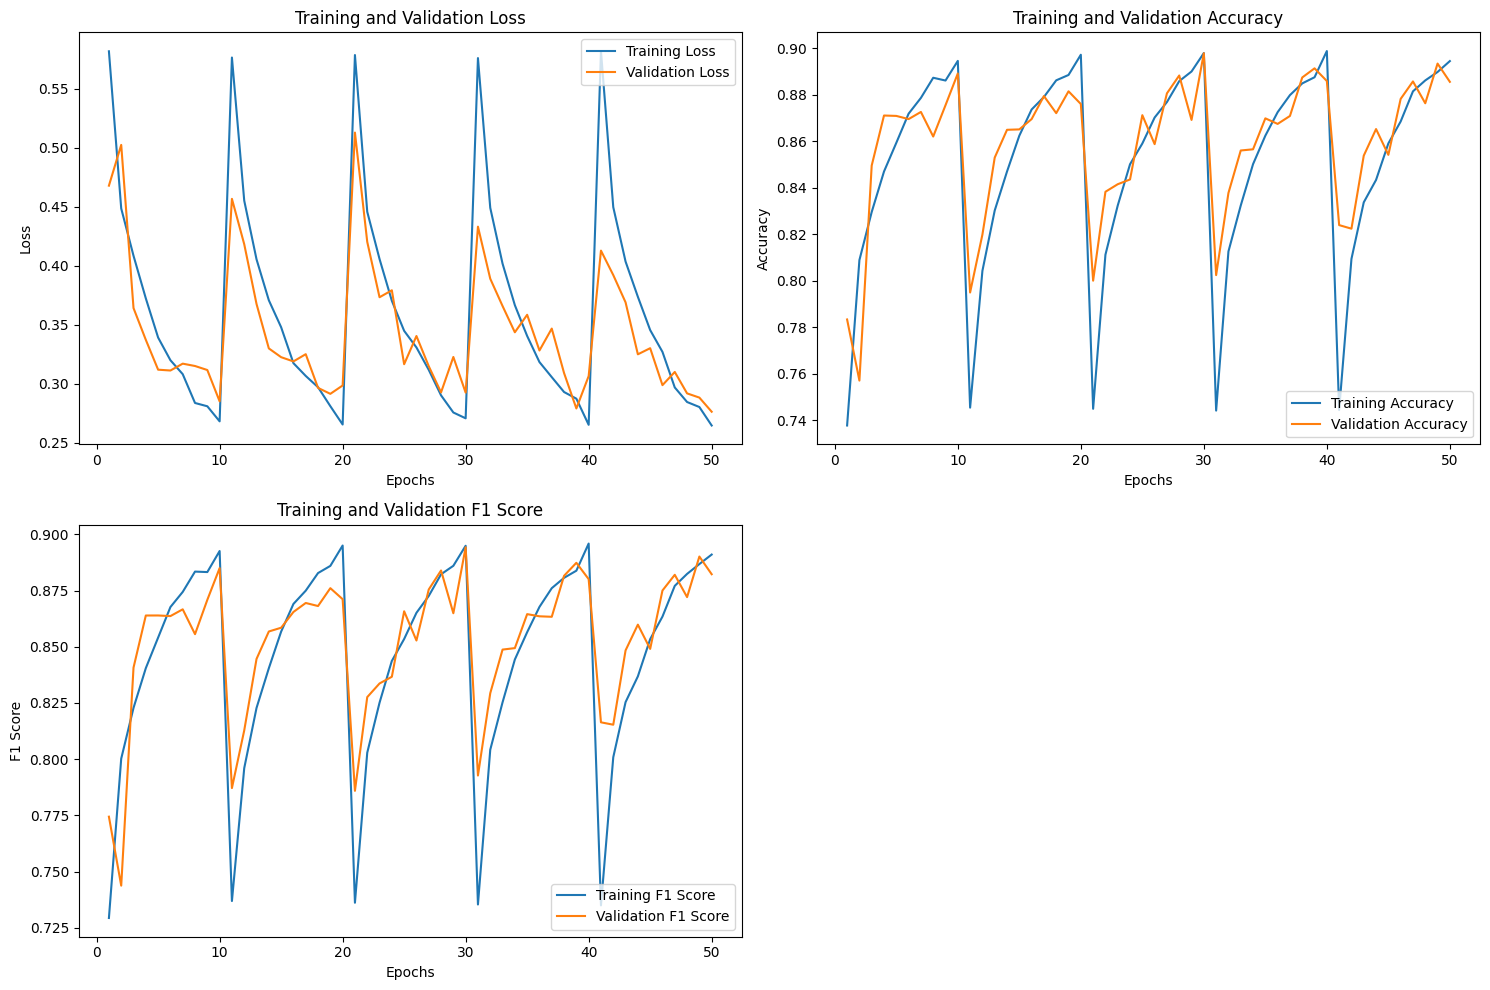

In [22]:
# Graficar las métricas
epochs = range(1, num_epochs * k_folds + 1)

plt.figure(figsize=(15, 10))

# Gráfico de la pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de la precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico del F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

# Definir transformaciones para las imágenes de prueba (deberían coincidir con las de entrenamiento)
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Tamaño estándar de entrada para modelos como VGG16 o ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización de imágenes
])

test_dir = '/kaggle/input/skin-burns-dataset/skin burn dataset/test'
# Cargar el conjunto de datos de prueba
test_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

In [26]:
print(test_images[0])

/kaggle/input/skin-burns-dataset/skin burn dataset/test/img878_jpg.rf.e636121a6ac3259ea86ef713220bd1d0.jpg


In [66]:
import torch
from torchvision import models
import torch.nn as nn
# Inicializar un nuevo modelo VGG16 con la misma arquitectura
vgg16 = models.vgg16(weights=None)


# Ajustar la arquitectura de la red según el modelo entrenado
# Modificar las capas de la sección classifier
vgg16.classifier[0] = nn.Linear(25088, 1024)  # Ajustar a 1024 neuronas
vgg16.classifier[3] = nn.Linear(1024, 512)    # Ajustar a 512 neuronas
vgg16.classifier[6] = nn.Linear(512, 3)       # Ajustar la última capa para 3 clases

# Enviar el modelo al dispositivo
vgg16 = vgg16.to(device)

load_path = '/kaggle/working/vgg16_entrenado.pth'
state_dict = torch.load(load_path)

# Remover las claves de la última capa
state_dict.pop('classifier.6.weight', None)
state_dict.pop('classifier.6.bias', None)

vgg16.load_state_dict(state_dict, strict=False)

vgg16.eval()

print(f"Modelo cargado correctamente desde: {load_path}")

Modelo cargado correctamente desde: /kaggle/working/vgg16_entrenado.pth


/tmp/ipykernel_30/4190519181.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path)


In [70]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

correct = 0
total = 0
all_preds = []
all_labels = []

# Deshabilitar gradientes para la evaluación
with torch.no_grad():
    for img_path in test_images:
        # Cargar y transformar la imagen
        image = Image.open(img_path).convert('RGB')
        image = test_transforms(image).unsqueeze(0).to(device)
        
        # Obtener predicciones
        outputs = vgg16(image)
        _, preds = torch.max(outputs, 1)

         # Guardar predicciones y etiquetas verdaderas
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Calcular el número de predicciones correctas
        correct += (preds == labels).sum().item()
        total += labels.size(0)

# Definir manualmente los nombres de las clases
class_names = ['1st degree burn', '2nd degree burn', '3rd degree burn']

# Contar las predicciones por clase
pred_counts = Counter(all_preds)

# Imprimir la cantidad de predicciones por clase
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {pred_counts.get(i, 0)} imágenes")

# Si tienes etiquetas verdaderas para las imágenes de prueba, utilízalas para generar el reporte de clasificación
# En este caso, no tenemos etiquetas, así que solo se mostrará la cantidad de predicciones por clase
if len(all_labels) > len(all_preds):
    all_labels = all_labels[:len(all_preds)]
elif len(all_preds) > len(all_labels):
    all_preds = all_preds[:len(all_labels)]

# Generar el reporte de clasificación
print(classification_report(all_labels, all_preds, target_names=class_names))

# Calcular accuracy
accuracy = correct / total
print(f'Accuracy del modelo: {accuracy:.2f}')


1st degree burn: 70 imágenes
2nd degree burn: 69 imágenes
3rd degree burn: 61 imágenes
                 precision    recall  f1-score   support

1st degree burn       0.46      0.34      0.39        95
2nd degree burn       0.35      0.38      0.36        63
3rd degree burn       0.15      0.21      0.17        42

       accuracy                           0.33       200
      macro avg       0.32      0.31      0.31       200
   weighted avg       0.36      0.33      0.34       200

Accuracy del modelo: 0.34


In [71]:
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)

[[32 26 37]
 [24 24 15]
 [14 19  9]]


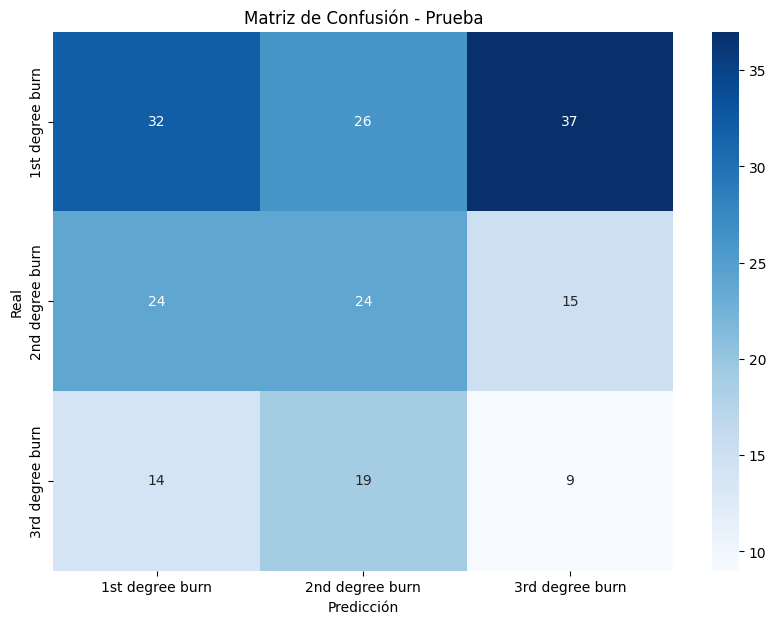

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Prueba')
plt.show()

In [47]:
from PIL import Image

# Definir manualmente los nombres de las clases
class_names = ['1st degree burn', '2nd degree burn', '3rd degree burn']

# Cargar una imagen de prueba individual
img_path = '/kaggle/input/skin-burns-dataset/skin burn dataset/test/img1056_jpg.rf.0348311befa7f18fc7b1e2224d7b989d.jpg'
image = Image.open(img_path)

# Aplicar las mismas transformaciones que durante la prueba
image = test_transforms(image).unsqueeze(0).to(device)

# Obtener predicción
with torch.no_grad():
    output = vgg16(image)
    _, pred = torch.max(output, 1)

# Mostrar la clase predicha usando la lista de nombres de clase
print(f"Predicción de la imagen: {class_names[pred.item()]}")


Predicción de la imagen: 1st degree burn


In [73]:
import pandas as pd

# Definir manualmente los nombres de las clases
class_names = ['1st degree burn', '2nd degree burn', '3rd degree burn']

# Crear un DataFrame con las predicciones
results_df = pd.DataFrame({'Imagen': [os.path.basename(img) for img in test_images],
                           'Predicción': [class_names[pred] for pred in all_preds]})

# Guardar el DataFrame a un archivo CSV
results_df.to_csv('/kaggle/working/resultados_prueba.csv', index=False)